<a href="https://colab.research.google.com/github/Quantzaar/Strategy/blob/main/backtest%20results/Backtest_nifty200_top10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#To upload file from local drive

#from google.colab import files

#uploaded = files.upload()

In [ ]:
# TO DO
# 11_1 momentum strategy
# 12_2 momentum strategy
# ma50>ma200 + top_5 momentum strategy
# nifty200 + top_10 + exit top_30_outside

# #######################################
# plot - mean monthly return on top_10 - so that we can identify when it performs and when it does not
#  similarly plot monthly return on other momentum strategy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
import os
cwd = os.getcwd()
print(cwd)

/content


In [2]:
import pandas as pd

filepath = r"/content/drive/MyDrive/Quantzaar-tradingS, InvestmentS, Trade&investMyTheory/Backtesting/ind_nifty200list.csv"

df=pd.read_csv(filepath)

In [3]:
df

,Company Name,Industry,Symbol,Series,ISIN Code
0,ABB India Ltd.,Capital Goods,ABB,EQ,INE117A01022
1,ACC Ltd.,Construction Materials,ACC,EQ,INE012A01025
2,APL Apollo Tubes Ltd.,Capital Goods,APLAPOLLO,EQ,INE702C01027
3,AU Small Finance Bank Ltd.,Financial Services,AUBANK,EQ,INE949L01017
4,Adani Energy Solutions Ltd.,Power,ADANIENSOL,EQ,INE931S01010
...,...,...,...,...,...
196,Wipro Ltd.,Information Technology,WIPRO,EQ,INE075A01022
197,Yes Bank Ltd.,Financial Services,YESBANK,EQ,INE528G01035
198,Zee Entertainment Enterprises Ltd.,Media Entertainment & Publication,ZEEL,EQ,INE256A01028
199,Zomato Ltd.,Consumer Services,ZOMATO,EQ,INE758T01015


0             ABB.NS
1             ACC.NS
2       APLAPOLLO.NS
3          AUBANK.NS
4      ADANIENSOL.NS
           ...      
196         WIPRO.NS
197       YESBANK.NS
198          ZEEL.NS
199        ZOMATO.NS
200     ZYDUSLIFE.NS
Name: Symbol, Length: 201, dtype: object


[*********************100%%**********************]  201 of 201 completed
[*********************100%%**********************]  1 of 1 completed


Annualized Return: 47.58%
Annualized Volatility: 26.09%
Sharpe Ratio: 1.82
Beta: 1.12
Maximum Drawdown: -27.68%


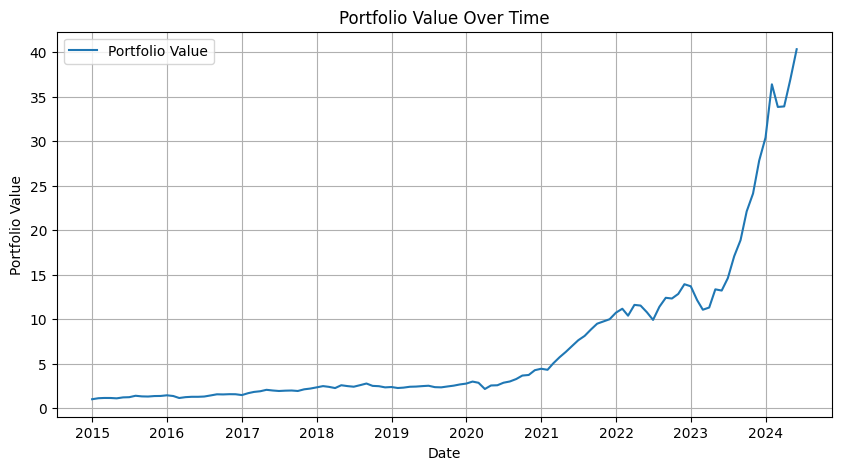

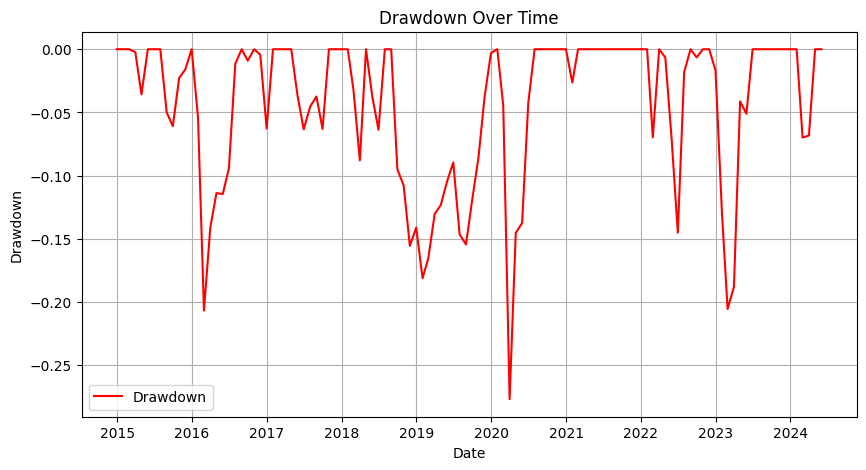

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get NIFTY 50 stock symbols
# stocks = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2].Symbol

stocks = df.Symbol + '.NS'
print(stocks)

# Download historical data
df = yf.download(stocks.to_list(), start='2014-01-01')
df_close = df['Adj Close']
df_dret = df_close.pct_change()
df_mret = (df_dret + 1).resample('M').prod() - 1

# Calculate 11-month rolling returns
df_mret_11 = df_mret.rolling(11).apply(lambda x: (x + 1).prod() - 1).dropna()

# Function to calculate top performers for a given date
def top_performers(date):
    top = df_mret_11.loc[date].nlargest(10)
    port_mret = df_mret[date:][1:2][top.index].mean(axis=1).values[0]
    return port_mret

# Calculate monthly returns of the strategy
monthly_ret = []
for date in df_mret_11.index[:-1]:
    monthly_ret.append(top_performers(date))

# Calculate portfolio value over time
portfolio_value = [1]
for r in monthly_ret:
    portfolio_value.append(portfolio_value[-1] * (1 + r))

# Create a DataFrame for portfolio value
portfolio_df = pd.DataFrame({
    'Date': df_mret_11.index[1:],
    'Portfolio Value': portfolio_value[1:]
})
portfolio_df.set_index('Date', inplace=True)

# Calculate drawdown
portfolio_df['Drawdown'] = portfolio_df['Portfolio Value'] / portfolio_df['Portfolio Value'].cummax() - 1

# Calculate Sharpe ratio
annualized_return = np.prod([1 + r for r in monthly_ret]) ** (12 / len(monthly_ret)) - 1
annualized_std = np.std(monthly_ret) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_std

# Calculate Beta
# Use NIFTY 50 index as benchmark
nifty50 = yf.download('^NSEI', start='2014-01-01')['Adj Close']
nifty50_mret = nifty50.pct_change().resample('M').apply(lambda x: (x + 1).prod() - 1).dropna()
cov_matrix = np.cov(nifty50_mret[df_mret_11.index[1]:], monthly_ret) #structure of monthly return?
beta = cov_matrix[0, 1] / cov_matrix[0, 0]

print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_std:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Beta: {beta:.2f}")
print(f"Maximum Drawdown: {portfolio_df['Drawdown'].min():.2%}")

# Plot portfolio value over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot drawdown over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df['Drawdown'], label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()
